# Idea

We will start with the ~~celebrity~~ (MINST for now!) faces dataset and then go on from there.

Broad idea:
1. Figure out how to get the ~~celebrity~~ images and then noise them.  
    a. This is probably relatively easy to do with pytortch as we can get the ~~celebrity~~ images from there.

    b. Adding noise too should be relatively simple.

    c. ~~We should resize the images, as they are very small for us to be able to just use the 'default' U-net architecture. (There is almost surely a way to make the U-net work for smaller images, but if we stick to the well-known implementation, it also allows for 
    us to widely apply the model for more advanced diffusion tasks)~~
    
    c. We will not be resizing the images, instead we will try to adapt the architecture to work with smaller images. This has multiple benefits i.e possibly faster training and allows for one to develop a more deeper understanding of how the actual U-net architecture works. 
2. Use an U-net to denoise the image. 
3. Display results. What might be even more cool would be to visualise the denoising and noising process. This should be relatively easy to do. 

# Imports, configuration

In [9]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
import matplotlib.pyplot as plt

In [2]:
# seems to be the standard
T = 1000
# sets up linspace as in the paper
betas = torch.linspace(10**-4,0.02,T)

Note on beta schedule: different approaches exist, but here we just replicate the approach used in [arxiv:2006.11239]

# Dataset initialisation

In [10]:
base_images = datasets.MNIST(
    root="data",
    train=True,
    download="True",
    # resizing images to make them big enough
    #transform=Compose([Resize(256),
                       #ToTensor()])
    transform=ToTensor()
)

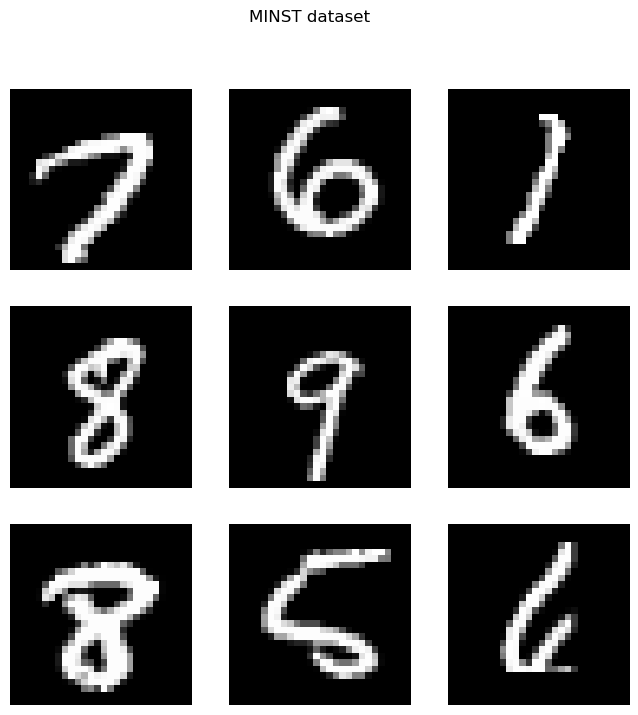

In [11]:
# just a quick plot to visualise the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(base_images), size=(1,)).item()
    img, label = base_images[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
figure.suptitle("MINST dataset")
plt.show()

# Noise addition

Use the gaussian reparameterization trick, we can write $q$ as
\begin{align*}
    q(x_t|x_0)=\mathcal{N}(x_t;\sqrt{\bar{\alpha}}x_0,(1-\hat{\alpha}_t)I)=\sqrt{\bar{\alpha}}x_0+\sqrt{(1-\hat{\alpha}_t)}\epsilon
\end{align*}
where $\epsilon\sim N(0,1)$. This also gives some mathematical intuition behind what is happening. We can for instance notice that as $t$ grows the original image decays further and further until we only have white noise. 

In [12]:
#define epsilon
# we have the dimension (1x28x28), from the definition
eps = torch.normal(0,1,(1,28,28))

# calculate alpha - this could be moved?
alphas = 1-betas

In [13]:
# helper function to add noise
# we could consider checking that image is a suitable type
def add_noise(input_image, t):
    alpha_bar = torch.prod(alphas[:t])
    output = torch.sqrt(alpha_bar)*input_image + torch.sqrt(1-alpha_bar)*eps
    return output

Text(0.5, 0.98, 'MINST dataset, additive noise visualisation')

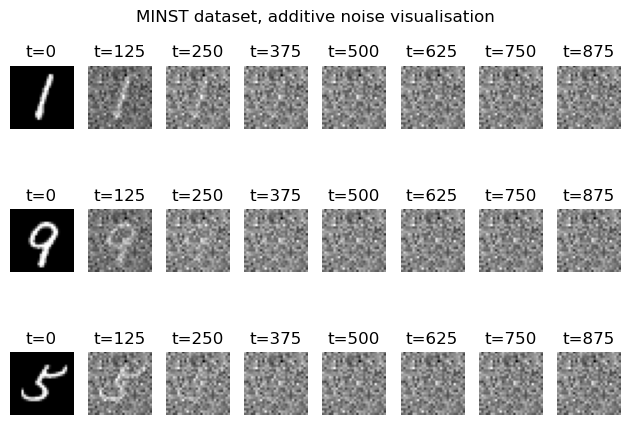

In [14]:
# allows us to test different time intervals - can be used for visualisation etc.
test_image, l = base_images[0]
x_t = add_noise(test_image, t=1000)

# basically we use the same value for steps and columns - but to make it clearer we do the assignment explicitly
# 6 steps for now
cols, rows = 8,3
steps = np.floor(T/cols)
time_int = torch.arange(0,T,step=steps,dtype=int)

fig, axs = plt.subplots(rows,cols)
for i in range(0,rows):
    sample_idx = torch.randint(len(base_images), size=(1,)).item()
    img, label = base_images[sample_idx]
    for j in range(0,cols):
        # add noise to image stepwise
        noised_image = add_noise(img, time_int[j])
        axs[i,j].imshow(noised_image.squeeze(),cmap="gray")
        axs[i,j].axis('off')
        axs[i,j].set_title(f't={time_int[j]}')
fig.tight_layout()
fig.suptitle("MINST dataset, additive noise visualisation")


The plot does seem to suggest that mabye a lower bound on T for a smaller image could work? Or the noise schedule needs to be adjusted - as we get a lot of noise very fast here. This might affect the results we get. 

# U-net construction, training

In [ ]:
# check if we have mps, cuda avaliable
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

#Define model
# We will use the original model introduced in 
# we are being lazy here and using the one provided* in 
# https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/
# note that we dont need the very final piece, as we want an image in the same 'form' as the input image to compare

# rough architecture
# input (1x28x28)
# (32x14^2)
class uNet(nn.Module):
    # Basically since we always use a 3x3 kernel we can do this:
    conv_stack = lambda in_channel, out_channel : nn.Sequential(
        nn.Conv2d(in_channel, out_channel, 3)
    )
    def __init__(self):
        super().__init__()
        # We can just use this, as maxpool/unpool only requires the window size.
        self.max_pool = nn.MaxPool2d(2)
        # fix this
        self.up_conv = nn.ConvTranspose2d(2)

        # the different stacks
        # c for channel staying the same
        # this is the 'down' part of the network
        self.conv_stack1= self.__class__.conv_stack(1,32)
        self.conv_stack1_c= self.__class__.conv_stack(32,32)

        self.conv_stack2 = self.__class__.conv_stack(64,64)
        self.conv_stack3 = self.__class__.conv_stack(64,32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self,x):
        # basically x_c[n] is for the concat connections
        # first level
        x = self.conv_stack1(x)
        x_conc_1 = self.conv_stack1_c(x)
        # max pool
        x = self.max_pool(x_conc_1)
        x = self.conv_stack2(x)
        x = self.conv_stack2(x)
        # upwards
        x = torch.concat((self.up_conv(x),x_conc_1))
        x = self.conv_stack2(x)
        # final output
        return self.final_conv(x)

model = uNet().to(device)
print(model)

loss_fn = torch.nn.functional.MSEloss()


Using mps device


TypeError: ConvTranspose2d.__init__() missing 2 required positional arguments: 'out_channels' and 'kernel_size'